In [2]:


# Nhập các thư viện cần thiết

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import nilearn as nl 
import nibabel as nib 
import nilearn.plotting as nlplt 
# !pip install https://github.com/miykael/gif_your_nifti.git # nifti to gif 

import gif_your_nifti.core as gif2nif 


import keras
import keras.backend as K
from keras.layers import Input, Flatten
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import preprocessing


np.set_printoptions(precision=3, suppress=True)



In [3]:


SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [4]:


# import os
TRAIN_DATASET_PATH = os.path.join('E:\\learn\\nkkh\\detetection\\dataset\\for_nifti_sengmentation\\data_brast_2020\\data\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData/')
VALIDATION_DATASET_PATH = os.path.join('E:\\learn\\nkkh\\detetection\\dataset\\for_nifti_sengmentation\\data_brast_2020\\data\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData/')

# test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
# test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
# test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
# test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
# test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
# slice_w = 25
# ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
# ax1.set_title('Image flair')
# ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
# ax2.set_title('Image t1')
# ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
# ax3.set_title('Image t1ce')
# ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
# ax4.set_title('Image t2')
# ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
# ax5.set_title('Mask')



In [5]:

# fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
# ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

In [6]:

# fig, ax1 = plt.subplots(1, 1, figsize = (15,15))

# ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [7]:

# shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
# gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

In [8]:


# niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
# nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

# fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


# nlplt.plot_anat(niimg,
#                 title='BraTS20_Training_001_flair.nii plot_anat',
#                 axes=axes[0])

# nlplt.plot_epi(niimg,
#                title='BraTS20_Training_001_flair.nii plot_epi',
#                axes=axes[1])

# nlplt.plot_img(niimg,
#                title='BraTS20_Training_001_flair.nii plot_img',
#                axes=axes[2])

# nlplt.plot_roi(nimask, 
#                title='BraTS20_Training_001_flair.nii with mask plot_roi',
#                bg_img=niimg, 
#                axes=axes[3], cmap='Paired')

# plt.show()

In [5]:


def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.

    Parameters
    ----------
    y_true: array-like
        Ground truth labels.
    y_pred: array-like
        Predicted labels.
    smooth: float
        Smoothing constant for the dice coefficient.

    Returns
    -------
    float
        Dice coefficient.

    """
    class_num = 4

    # Compute per-class intersection and union areas.
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)

        # Compute the dice coefficient for this class.
        loss = ((2. * intersection + smooth) /
                (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        # Print dice coefficient for each class.
        K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))

        # Add to the total loss.
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    # Average the loss over classes.
    total_loss = total_loss / class_num

    return total_loss


 
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    """Compute the dice coefficient for the necrotic class.

    The dice coefficient là thước đo sự giống nhau giữa hai nhãn
    phân phối. It ranges from 0 (no similarity) to 1 (perfect match).

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        epsilon: Smoothing constant to avoid division by zero.

    Returns:
        Dice coefficient.
    """
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    """Compute the dice coefficient for the edema class.

    The dice coefficient is a measure of the similarity between two label
    distributions. It ranges from 0 (no similarity) to 1 (perfect match).

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        epsilon: Smoothing constant to avoid division by zero.

    Returns:
        Dice coefficient.
    """

    # Intersection is the number of pixels that are the same in both y_true and
    # y_pred. Convert to float() so that division is floating-point division.
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))

    # Denominator is the total number of pixels in y_true plus y_pred. The
    # epsilon value is added to avoid division by zero.
    denominator = K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon

    # Dice coefficient is (2 * intersection) / (denominator).
    return (2. * intersection) / denominator

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    """Compute the dice coefficient for the enhancing tumor class.

    The dice coefficient is a measure of the similarity between two label
    distributions. It ranges from 0 (no similarity) to 1 (perfect match).

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        epsilon: Smoothing constant to avoid division by zero.

    Returns:
        Dice coefficient.
    """

    # Intersection is the number of pixels that are the same in both y_true and
    # y_pred. Convert to float() so that division is floating-point division.
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))

    # Denominator is the total number of pixels in y_true plus y_pred. The
    # epsilon value is added to avoid division by zero.
    denominator = K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon

    # Dice coefficient is (2 * intersection) / (denominator).
    return (2. * intersection) / denominator
 
def precision(y_true, y_pred):
    """Compute precision for the given true and predicted labels.

    Precision is the ratio of True Positives to True Positives plus False Positives.
    It measures the ratio of correctly identified positive samples out of all
    positive samples that were identified as positive.

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.

    Returns:
        Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
def sensitivity(y_true, y_pred):
    """
    Compute sensitivity for the given true and predicted labels.

    Sensitivity is the ratio of True Positives to True Positives plus False Negatives.
    It measures the ratio of correctly identified positive samples out of all
    actual positive samples.

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.

    Returns:
        Sensitivity metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    """Compute specificity for the given true and predicted labels.

    Specificity is the ratio of True Negatives to True Negatives plus False Positives.
    It measures the ratio of correctly identified negative samples out of all
    actual negative samples.

    Arguments:
        y_true: Ground truth labels.
        y_pred: Predicted labels.

    Returns:
        Specificity metric.
    """
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [6]:


IMG_SIZE=128

In [7]:


def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [8]:


train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    """
    Takes a list of directory paths and returns a list of the directory names

    Parameters
    ----------
    dirList : list
        List of directory paths

    Returns
    -------
    list
        List of directory names
    """
    x = []
    for i in range(0,len(dirList)):
        # For each directory path, find the last '/' and return the substring
        # from there to the end of the string
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x



train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 



In [9]:


class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


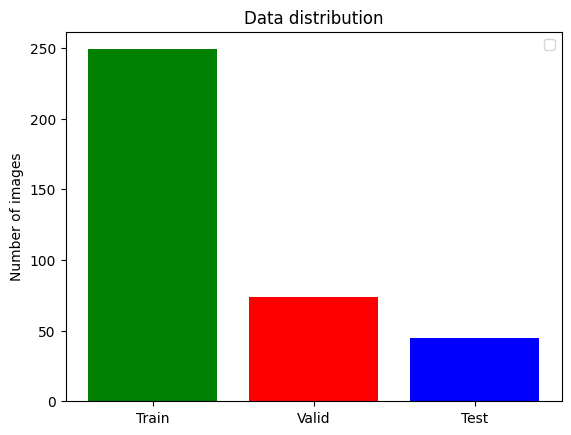

In [10]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [11]:


csv_logger = CSVLogger('./ouput_model/training.log', separator=',', append=False)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                              patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                            verbose=1, save_best_only=True, save_weights_only = True),
    csv_logger
]

In [16]:


K.clear_session()

history =  model.fit(training_generator,
                    epochs=12,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("./ouput_model/model_x1_1.h5")





Epoch 1/12
loss value for class NOT tumor :  0.429912806
loss value for class NECROTIC/CORE :  0.000160216383
loss value for class EDEMA :  0.0030215946
loss value for class ENHANCING :  0.00154431
  1/249 [..............................] - ETA: 2:03:01 - loss: 1.3003 - accuracy: 0.4291 - mean_io_u: 0.3752 - dice_coef: 0.1087 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.9999 - dice_coef_necrotic: 5.6811e-04 - dice_coef_edema: 0.0140 - dice_coef_enhancing: 0.0060loss value for class NOT tumor :  0.982300103
loss value for class NECROTIC/CORE :  7.78572576e-05
loss value for class EDEMA :  5.2186886e-05
loss value for class ENHANCING :  4.00203207e-05
  2/249 [..............................] - ETA: 1:32:08 - loss: 4.4903 - accuracy: 0.7003 - mean_io_u: 0.6298 - dice_coef: 0.1771 - precision: 0.4858 - sensitivity: 0.4843 - specificity: 0.9952 - dice_coef_necrotic: 2.8406e-04 - dice_coef_edema: 0.0070 - dice_coef_enhancing: 0.0030        loss value for class NOT tumor

c:\Users\toanv\miniconda3\envs\d2l\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:


# Load the model
model = keras.models.load_model(
    r'E:\\learn\\nkkh\\detetection\\sengmentation\\ouput_model\\model_x1_1.h5',
    custom_objects={
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_necrotic,
        'dice_coef_edema': dice_coef_edema,
        'dice_coef_enhancing': dice_coef_enhancing
    },
    compile=False
)

# Load the training history
hist = pd.read_csv(
    r'E:\\learn\\nkkh\\detetection\\sengmentation\\ouput_model\\training.log',
    sep=',',
    engine='python'
)

epoch = hist['epoch']
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

# Plotting
f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[2].legend()

# Corrected column names for mean IOU
ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation mean IOU')
ax[3].legend()

plt.show()

NameError: name 'keras' is not defined

In [13]:



def imageLoader(path):
    """
    Tải tệp Nifti tại `path`
    và trả lại một mảng hình dạng numpy
    (Batch_Size * n_slices, x, y, n_channels)
    trong đó n_channels là số lượng kênh trong dữ liệu đầu vào
    và mỗi lát được thay đổi kích thước thành (img_size, img_size)
    """
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        # resize input data to (IMG_SIZE, IMG_SIZE)
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        # resize corrupted data to (IMG_SIZE, IMG_SIZE)
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        # each slice is a binary mask
        # so y is a numpy array of shape (batch_size * n_slices, x, y)
        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
    return np.array(image)


def loadDataFromDir(path, list_of_files, mriType, n_images):
    """
    Tải các tệp Nifti từ đường dẫn có tên trong list_of_files [: n_images]
    và trả về cặp mảng numpy:
    (X, y) trong đó x là một mảng hình dạng
    (n_images * n_slices, x, y, n_channels)
    và y là một mảng hình dạng numpy
    (n_images * n_slices, x, y)
    trong đó n_slices là số lượng lát trong mỗi tệp Nifti đầu vào,
    x và y là kích thước hình ảnh sau khi thay đổi kích thước
    và N_Channels là số lượng kênh trong dữ liệu đầu vào.

    Arguments:
        Đường dẫn: Đường dẫn đến thư mục với các tệp NIFTI
        list_of_files: Danh sách tên tệp trong thư mục
        mritype: chuỗi sẽ được sử dụng để lọc
            Nifti Tệp theo tên của họ
        N_Images: số lượng tệp Nifti để tải
    """
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob(os.path.join(path, i + '/*' + mriType + '*'))[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader(glob.glob(os.path.join(path, i + '/*seg*'))[0])
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
          
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)




4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

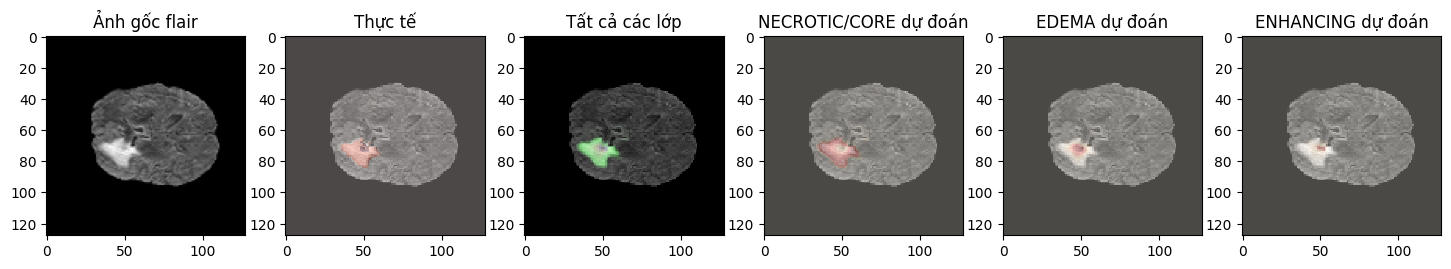

101
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

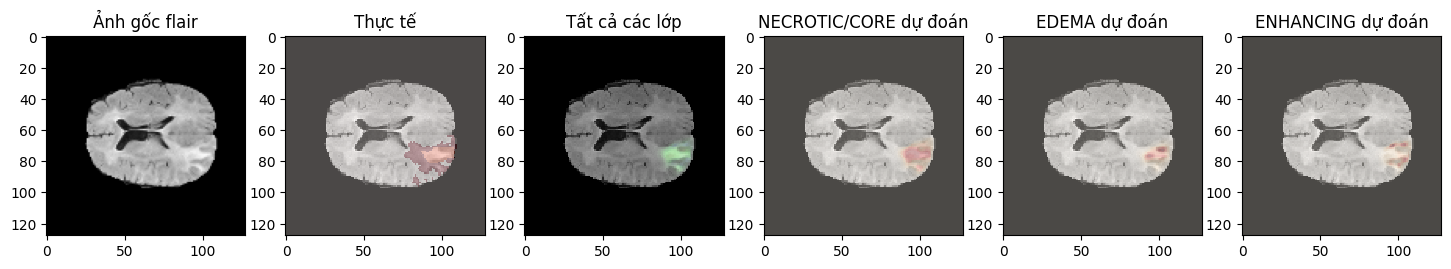

125
4/4 [==============================] - 7s 1s/step


<Figure size 1800x5000 with 0 Axes>

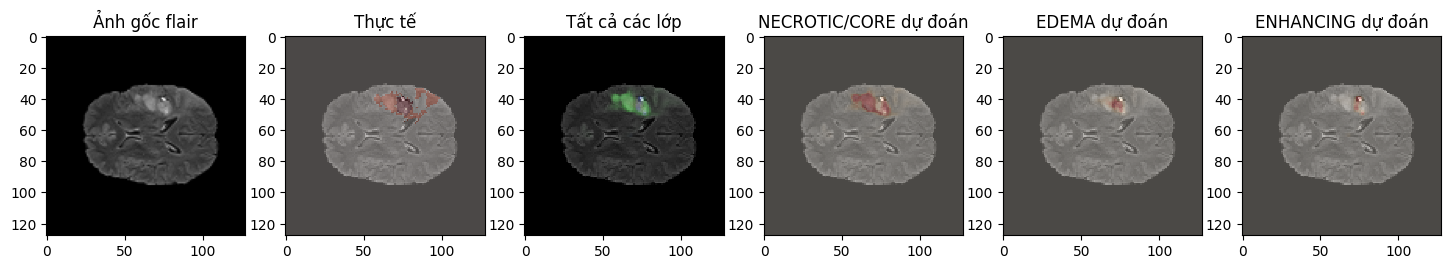

101
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

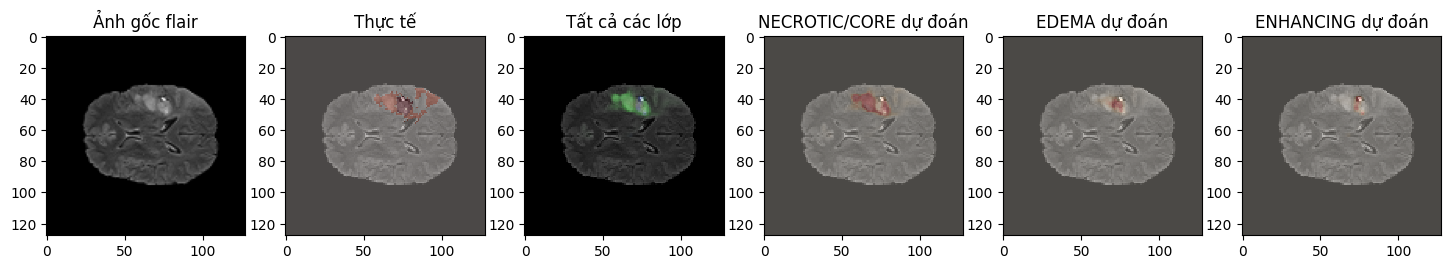

034
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

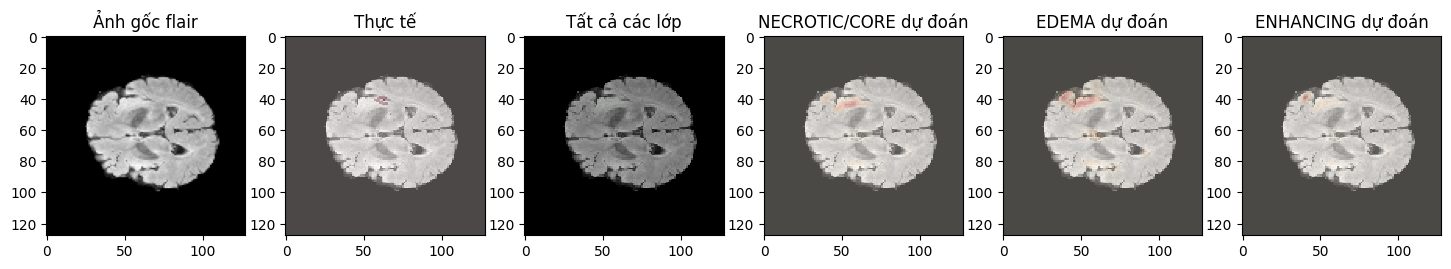

094
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

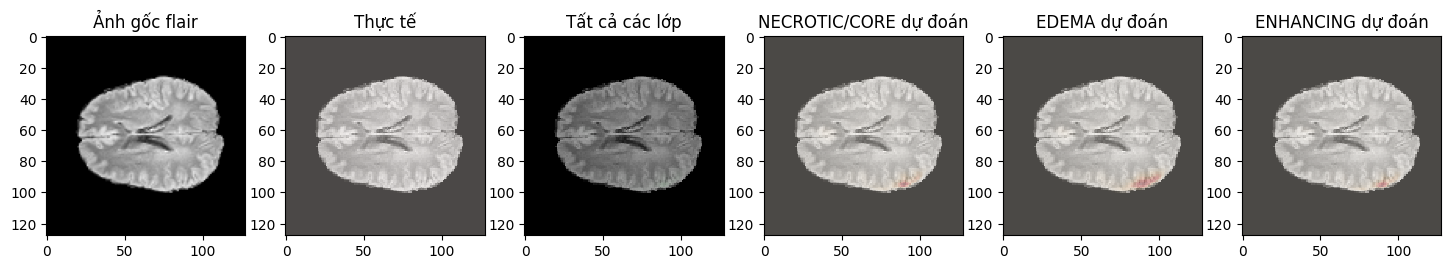

125
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

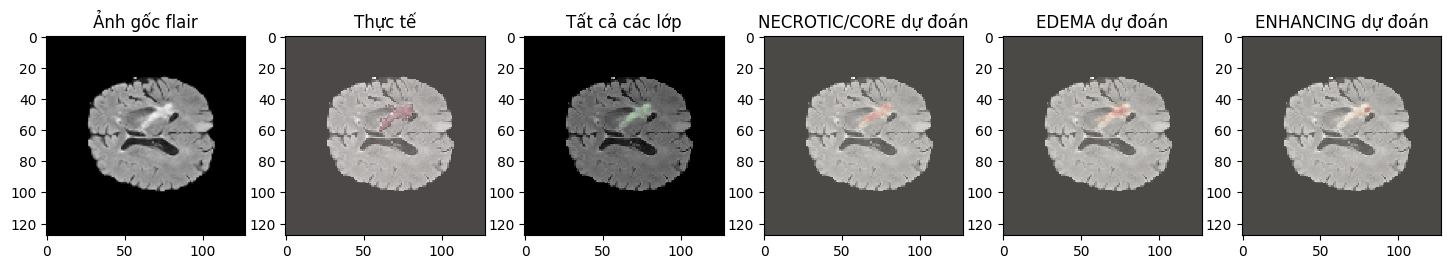

034
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

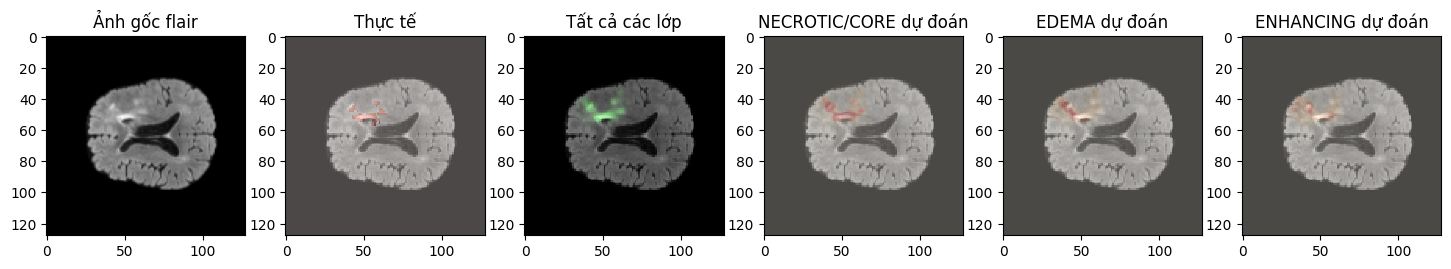

335
4/4 [==============================] - 6s 2s/step


<Figure size 1800x5000 with 0 Axes>

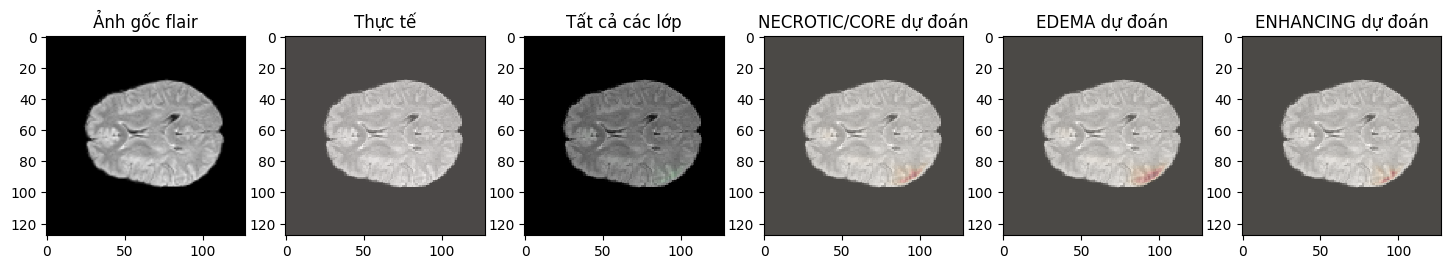

335
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

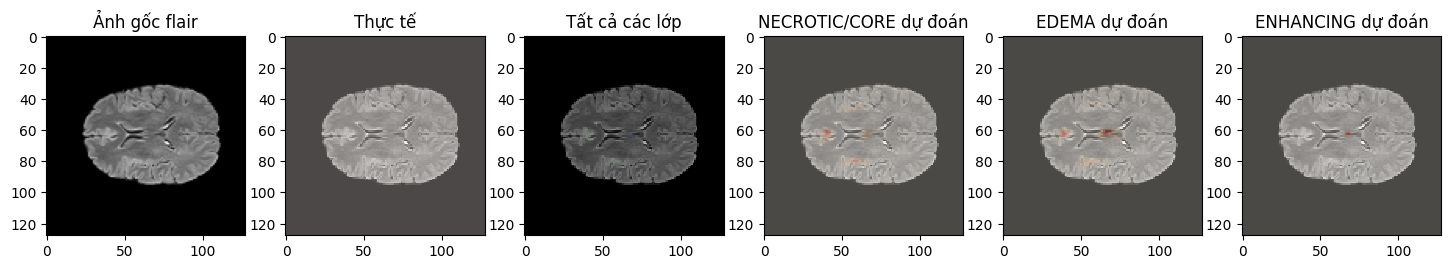

332
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

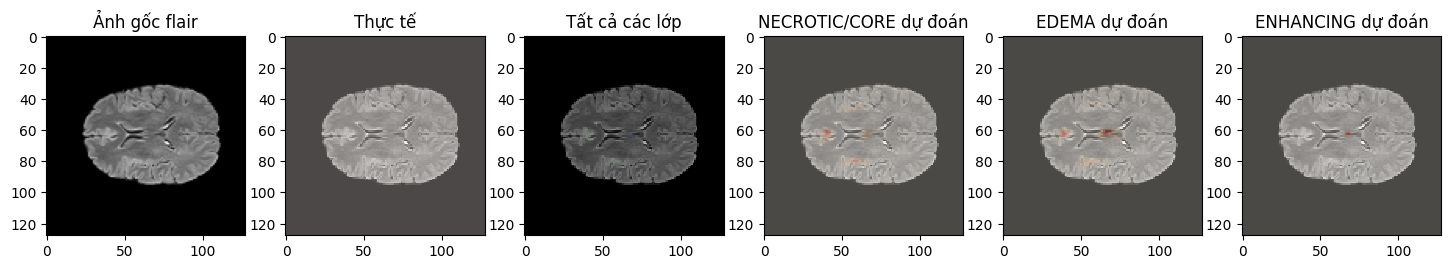

095
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

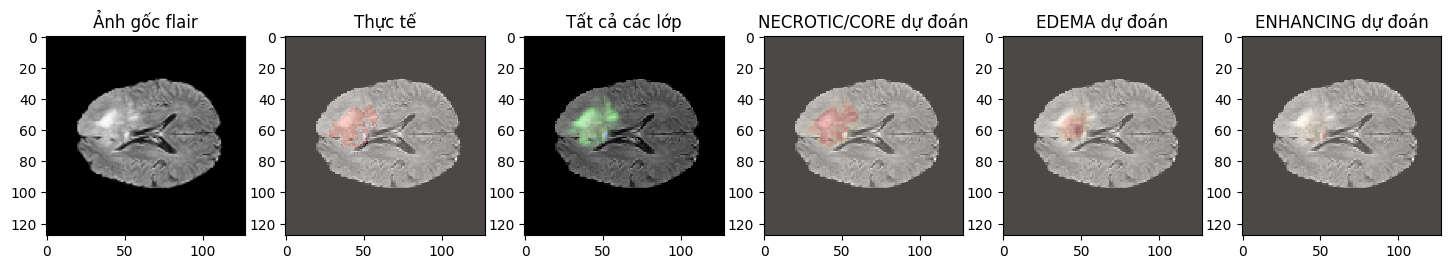

030
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

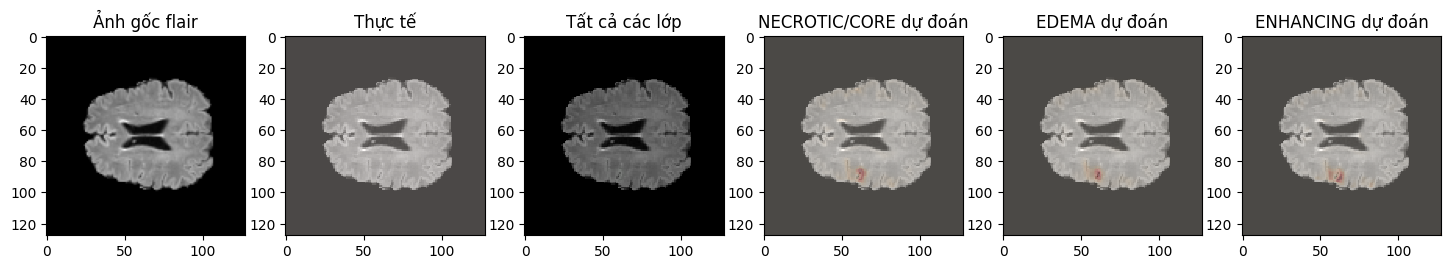

031
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

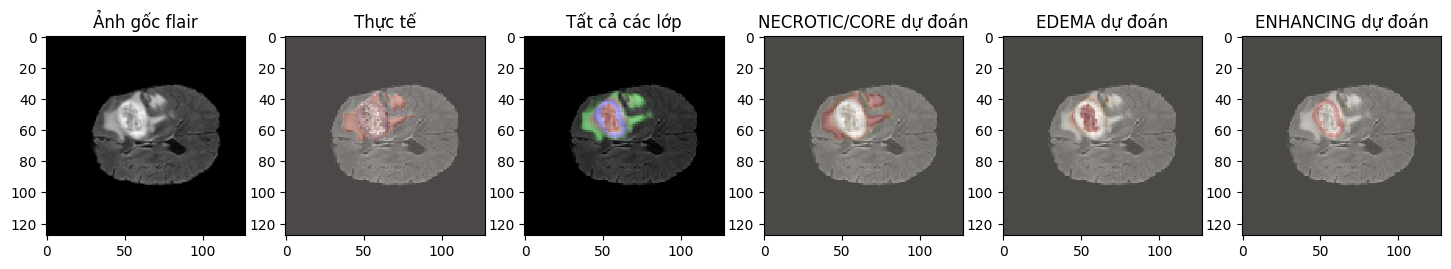

332
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

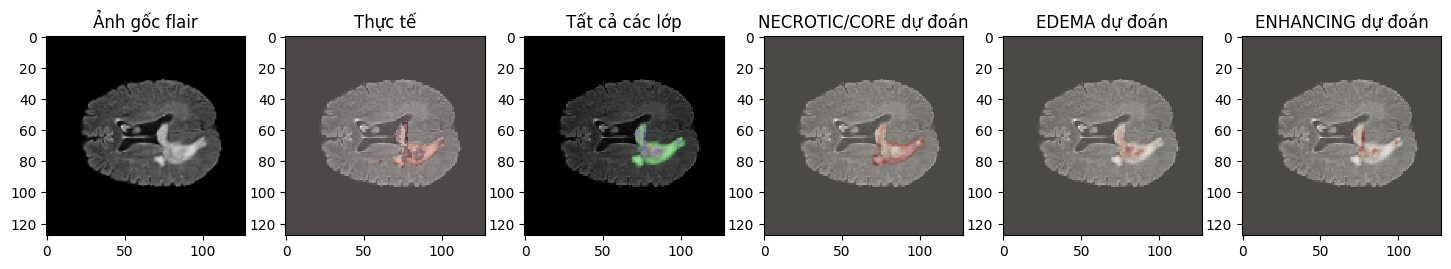

332
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

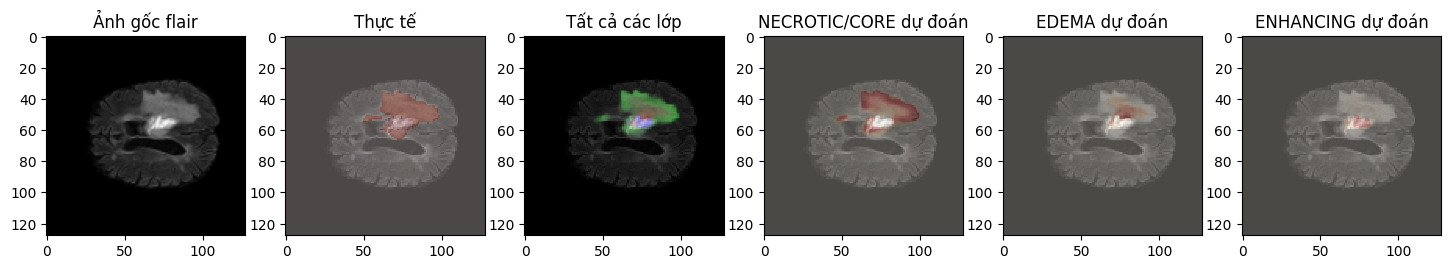

101
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

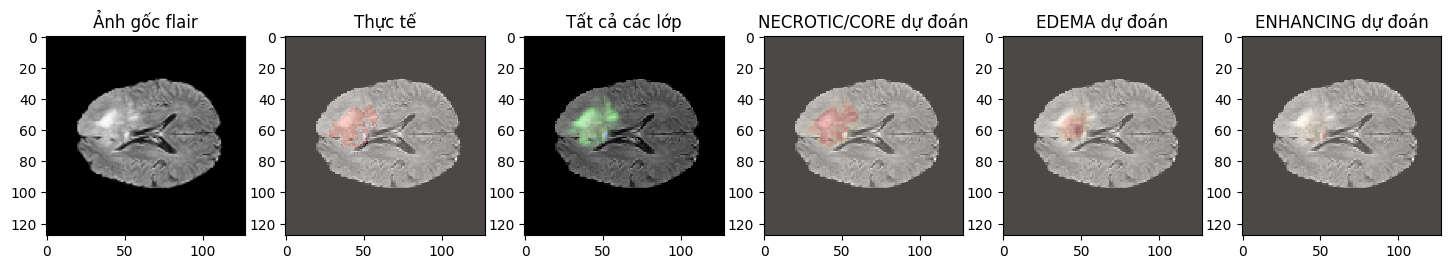

015
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

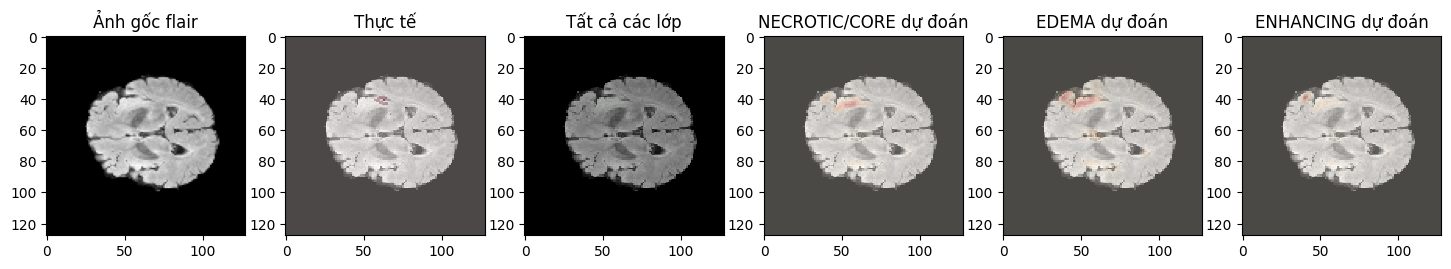

262
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

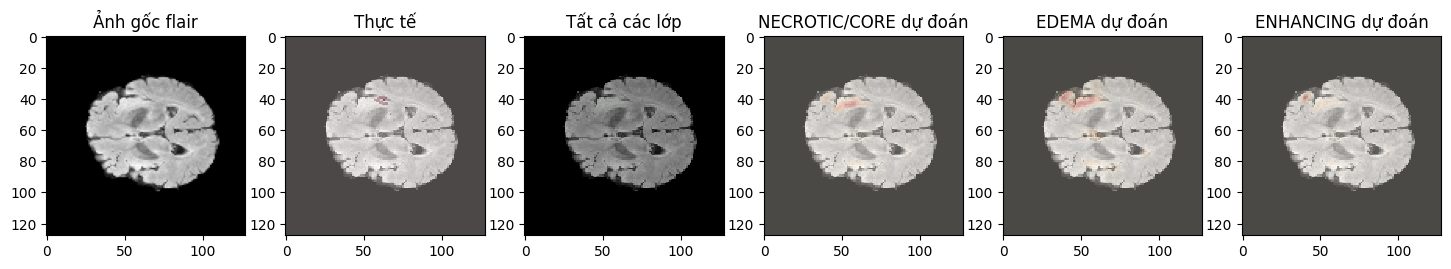

083
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

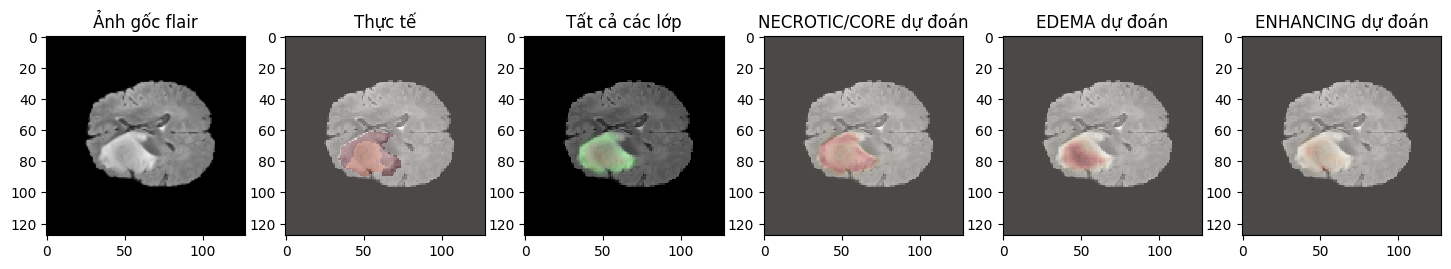

083
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

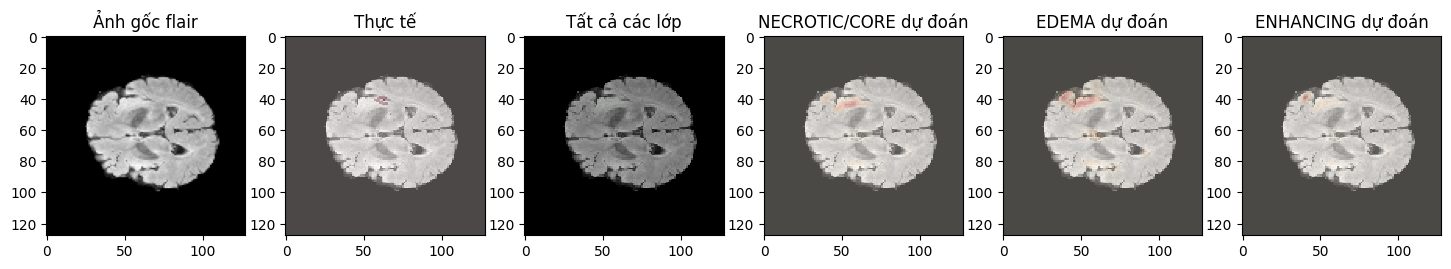

331
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

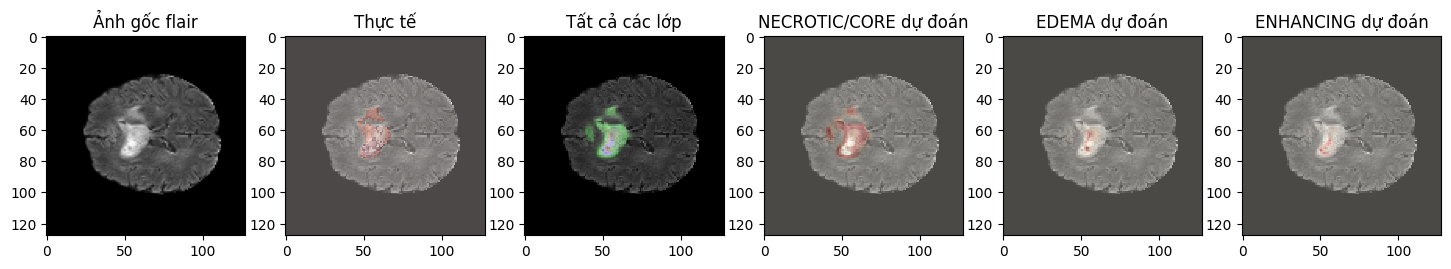

151
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

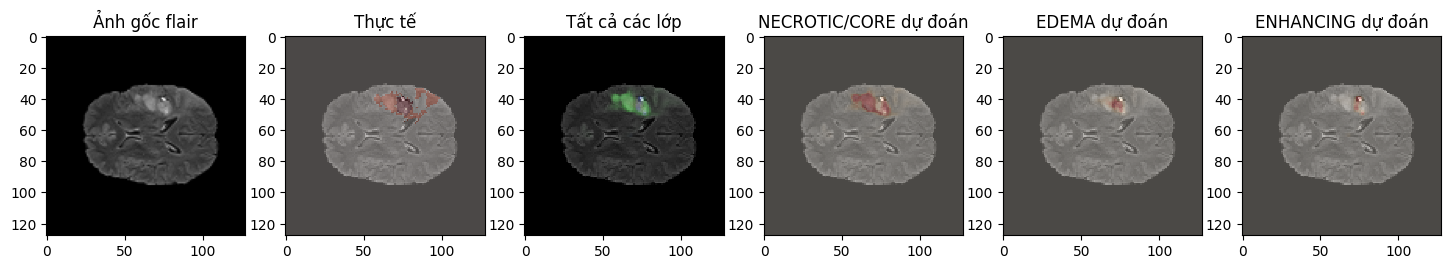

125
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

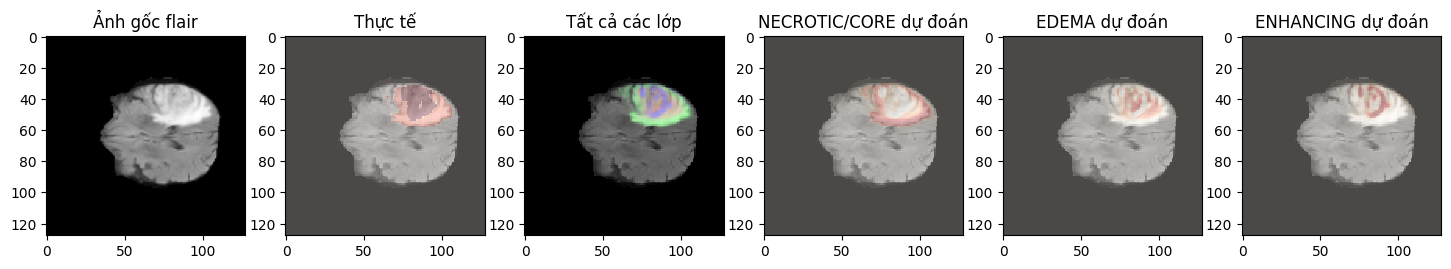

331
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

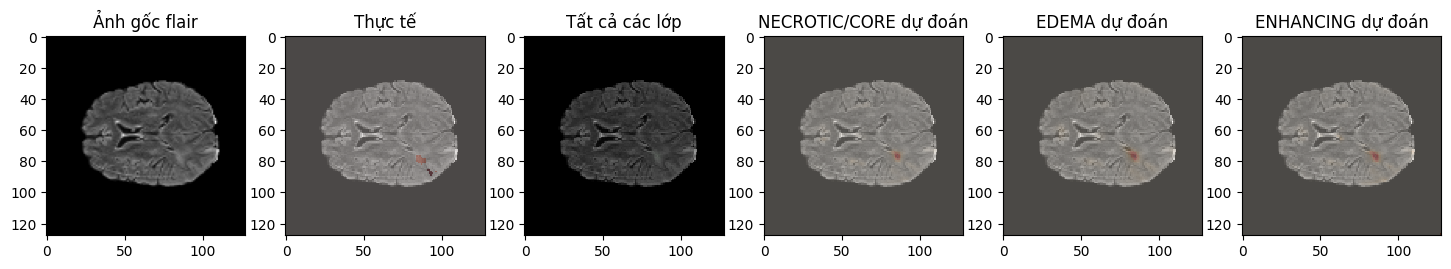

157
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

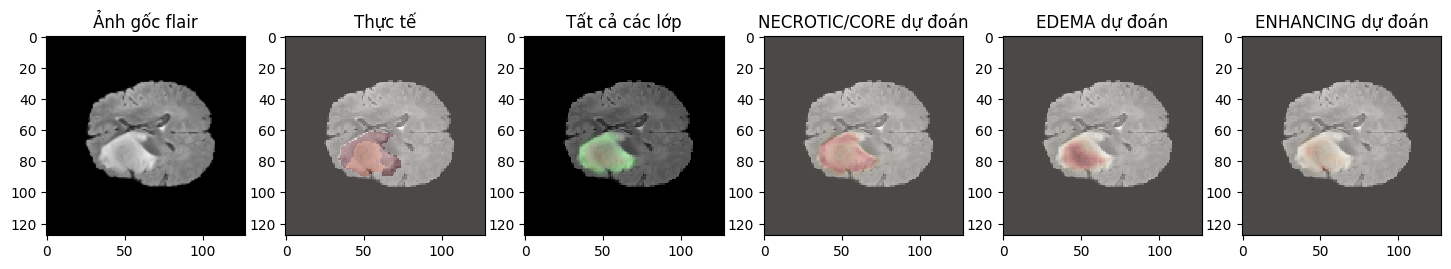

031
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

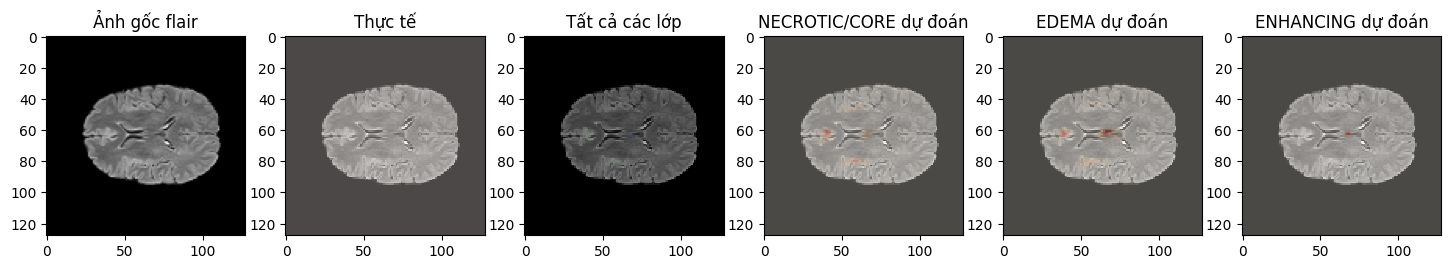

151
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

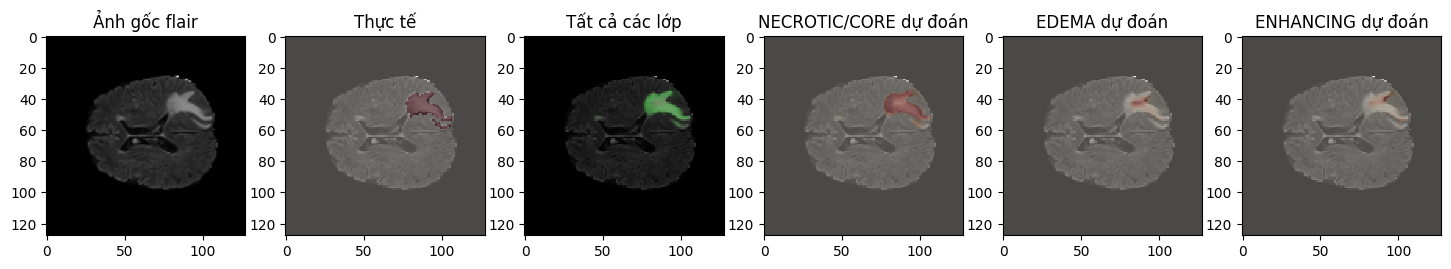

125
4/4 [==============================] - 7s 1s/step


<Figure size 1800x5000 with 0 Axes>

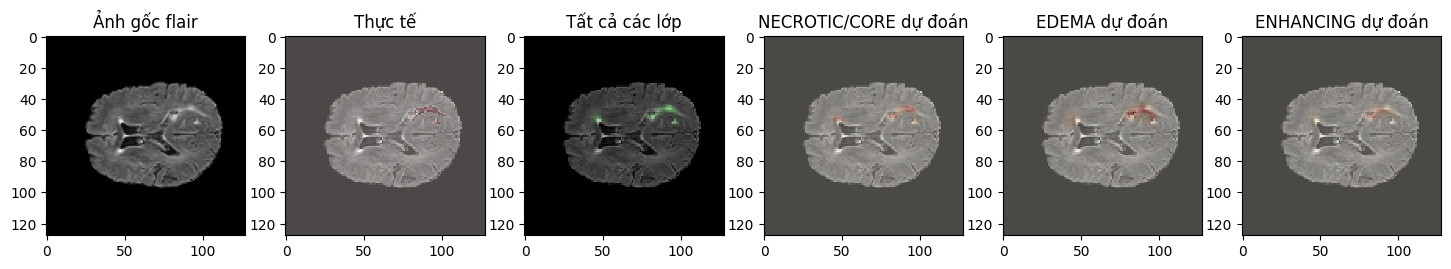

083
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

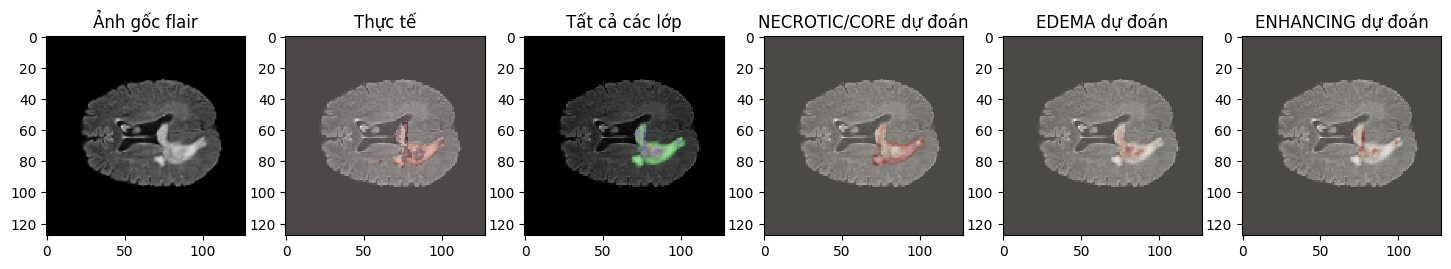

058


In [15]:

def predictByPath(case_path, case):
    # Lấy danh sách tệp trong thư mục case_path
    files = next(os.walk(case_path))[2]
    # Khởi tạo mảng X với kích thước (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2)
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    # Đường dẫn đến tệp ảnh flair
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    # Tải ảnh flair
    flair = nib.load(vol_path).get_fdata()
    # Đường dẫn đến tệp ảnh ce
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    # Tải ảnh ce
    ce = nib.load(vol_path).get_fdata() 
    # Lặp qua các lát cắt trong tập ảnh
    for j in range(VOLUME_SLICES):
        # Thay đổi kích thước lát cắt flair và thêm vào mảng inputs X
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        # Thay đổi kích thước lát cắt ce và thêm vào mảng inputs X
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
    # Dự đoán mặt nạ của tệp
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    # Đường dẫn đến thư mục chứa dữ liệu của case
    path = f"E:\\learn\\nkkh\\detetection\\dataset\\for_nifti_sengmentation\\data_brast_2020\\data\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_{case}"
    # Tải ảnh mặt nạ thực tế
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    # Tải ảnh gốc
    # origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    # Dự đoán mặt nạ sử dụng hàm predictByPath
    p = predictByPath(path, case)
    # Rút trích các mặt nạ dự đoán cho các lớp khác nhau của khối u não
    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]
    # Tạo plot
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))
    # Hiển thị hình ảnh gốc
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].set_title('Ảnh gốc flair')
    # Hiển thị mặt nạ thực tế
    curr_gt = cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Thực tế')
    # Hiển thị tất cả các lớp dự đoán
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('Tất cả các lớp')
    # Hiển thị mặt nạ cho lớp Edema
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} dự đoán')
    # Hiển thị mặt nạ cho lớp Core
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} dự đoán')
    # Hiển thị mặt nạ cho lớp Enhancing
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} dự đoán')
    plt.show()


import random as rd
# Hiển thị dự đoán cho các case khác nhau
# showPredictsById(case=test_ids[0][-3:])
for id in range(30):
    showPredictsById(case=test_ids[rd.randint(1,30)][-3:])
    print(test_ids[rd.randint(1,30)][-3:])




4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

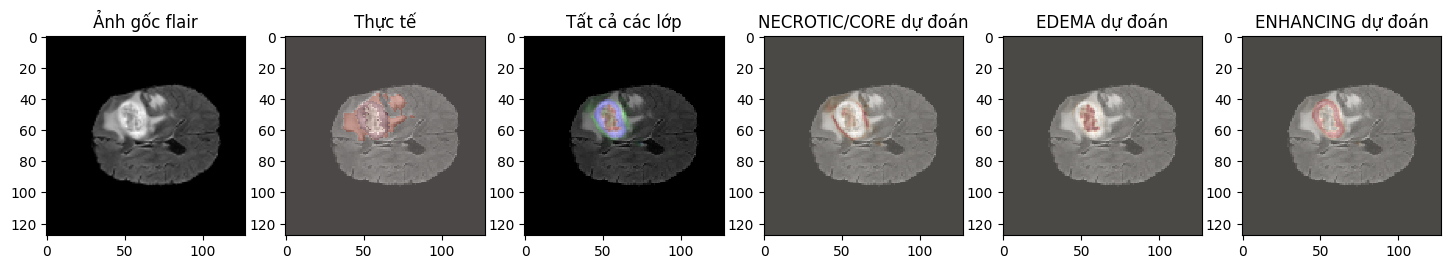

231
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

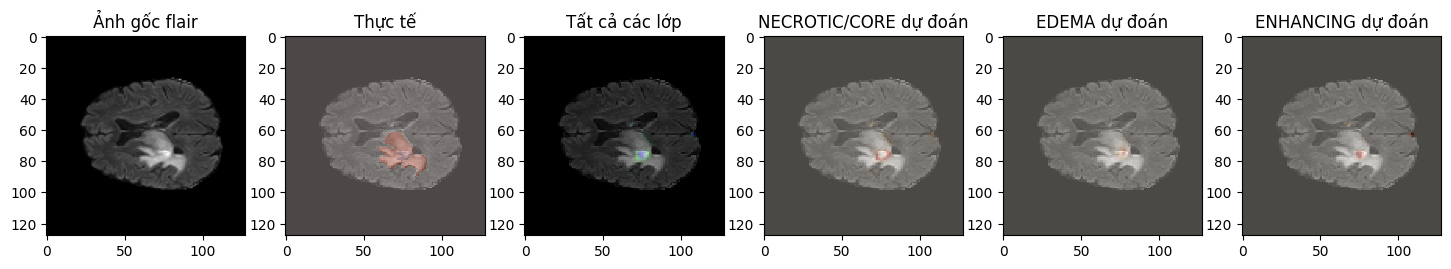

206
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

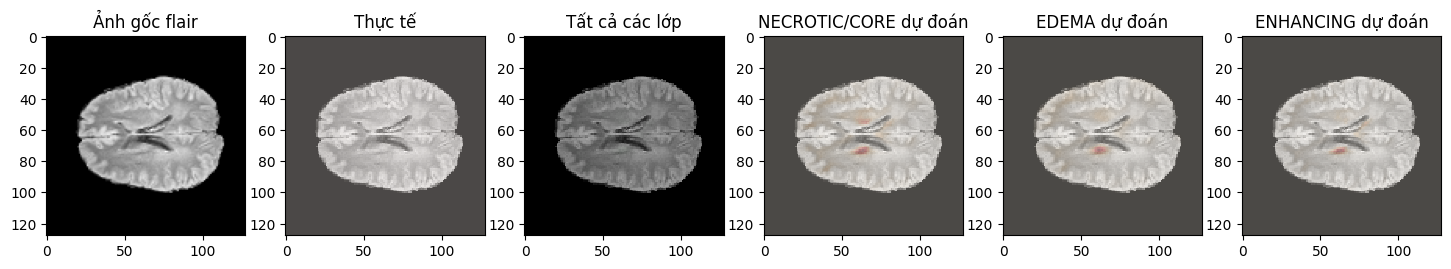

158
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

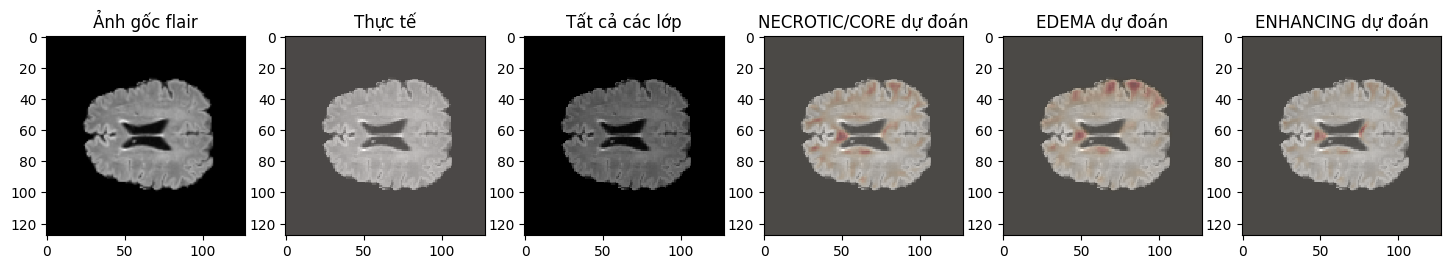

276
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

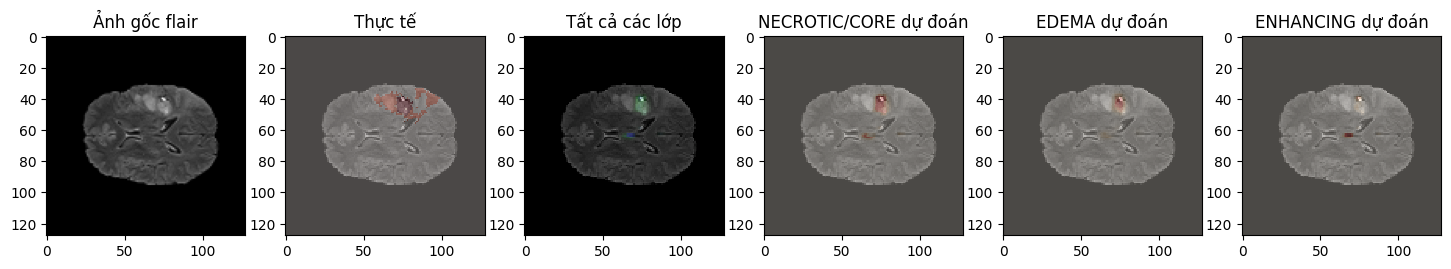

157
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

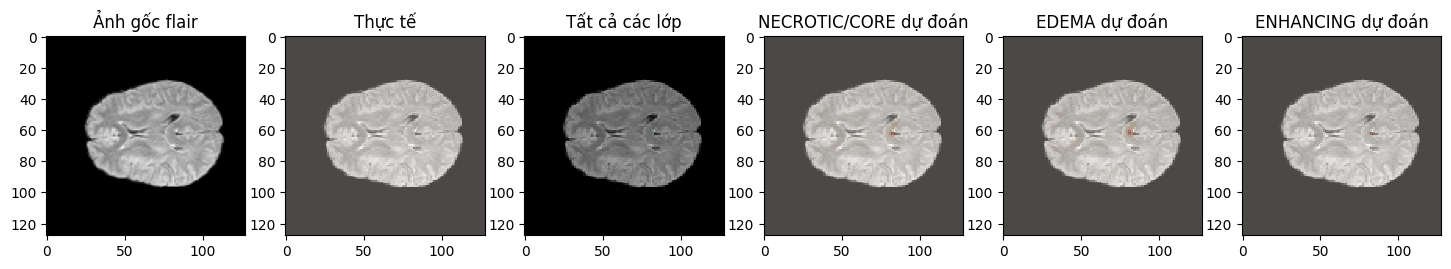

231
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

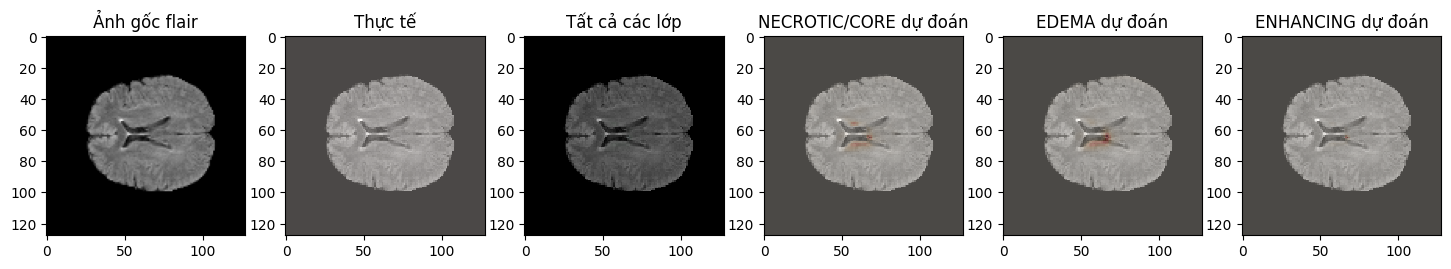

015
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

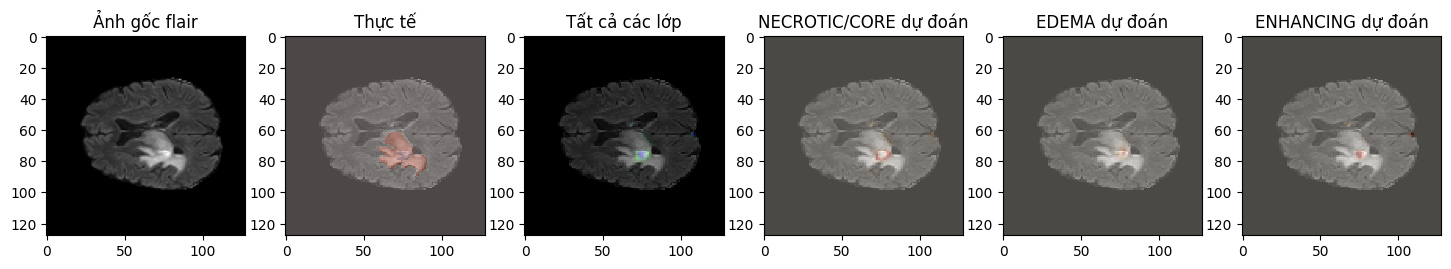

125
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

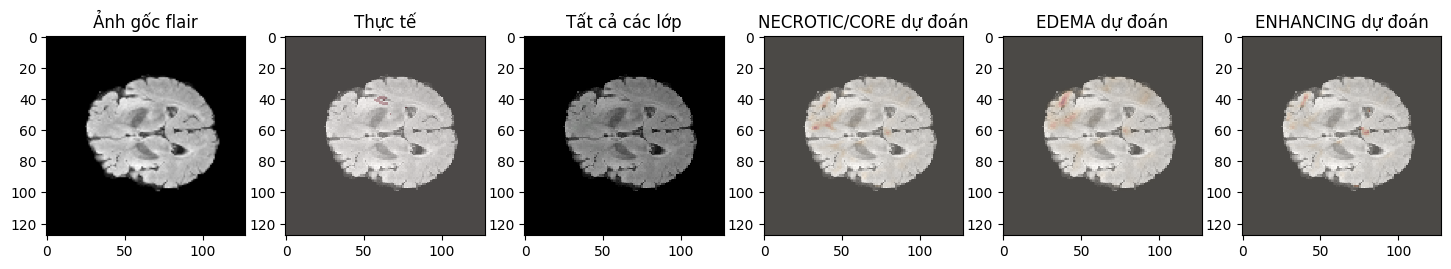

041
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

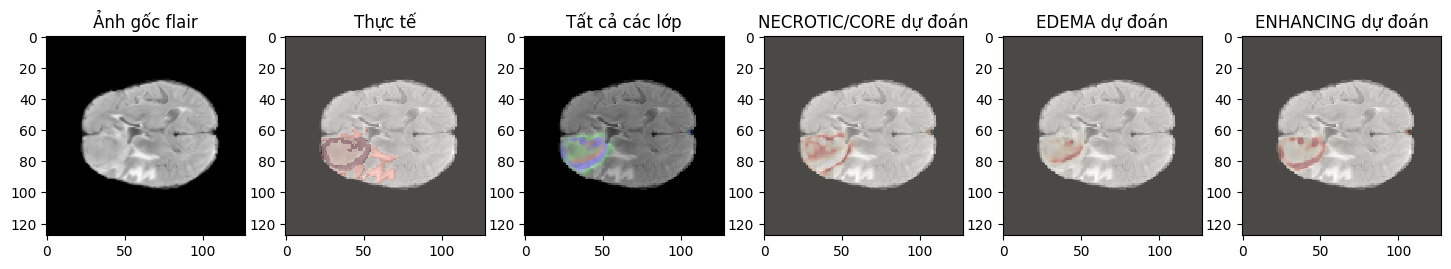

335
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

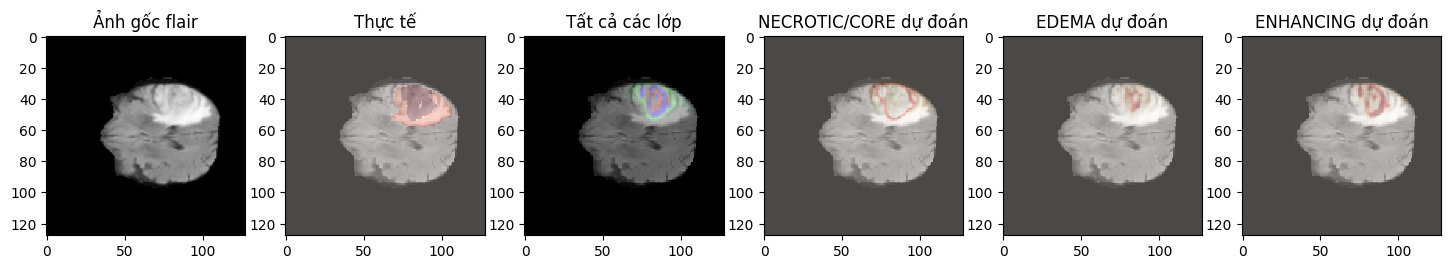

062
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

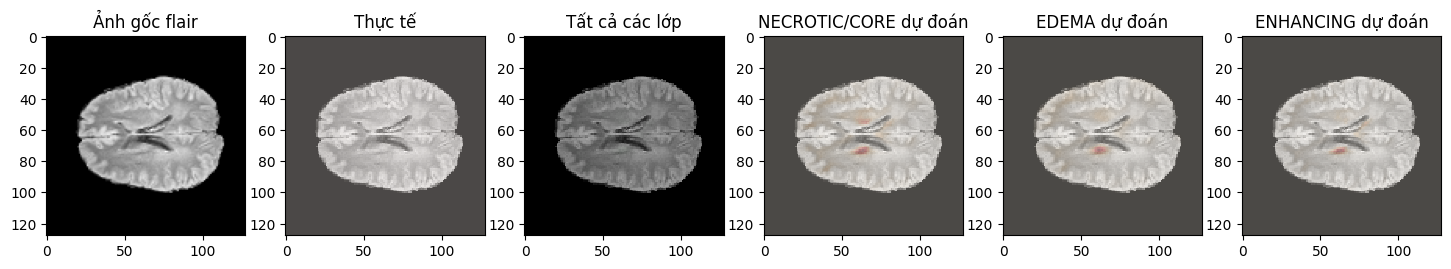

095
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

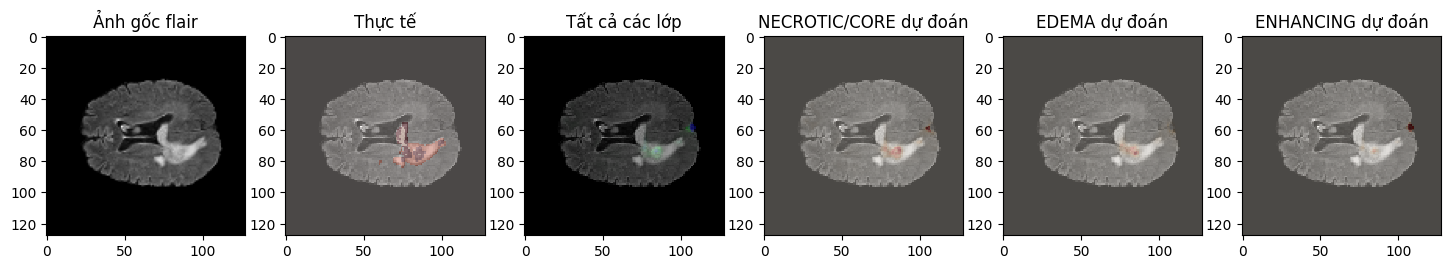

158
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

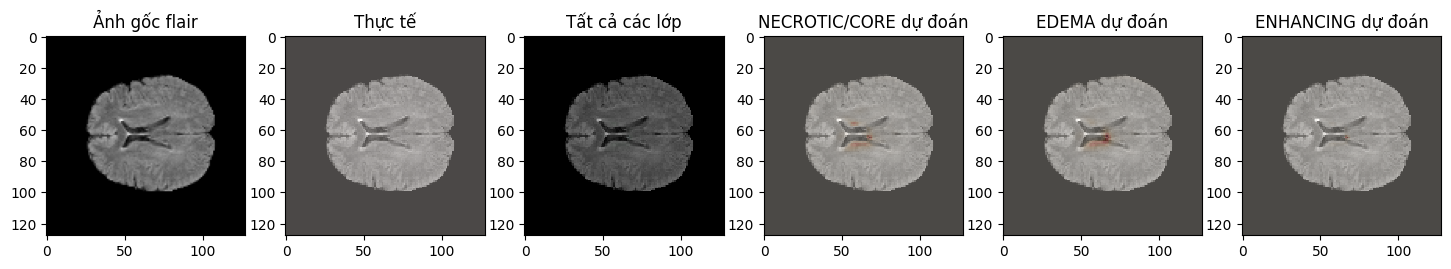

080
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

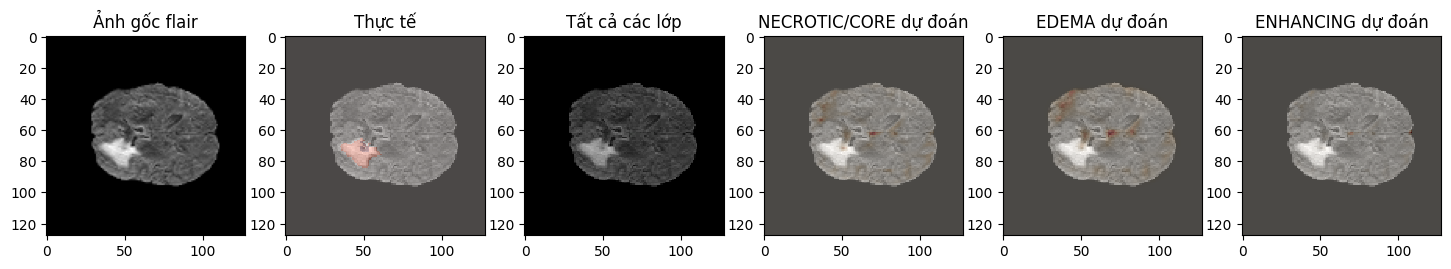

080
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

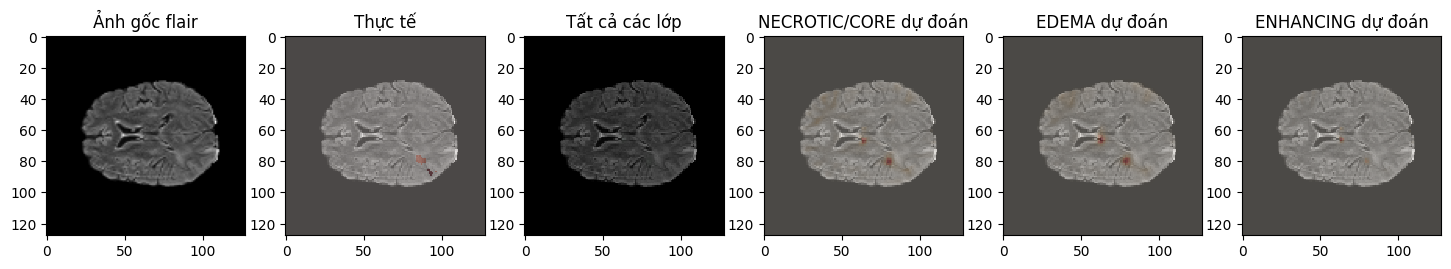

335
4/4 [==============================] - 6s 1s/step


<Figure size 1800x5000 with 0 Axes>

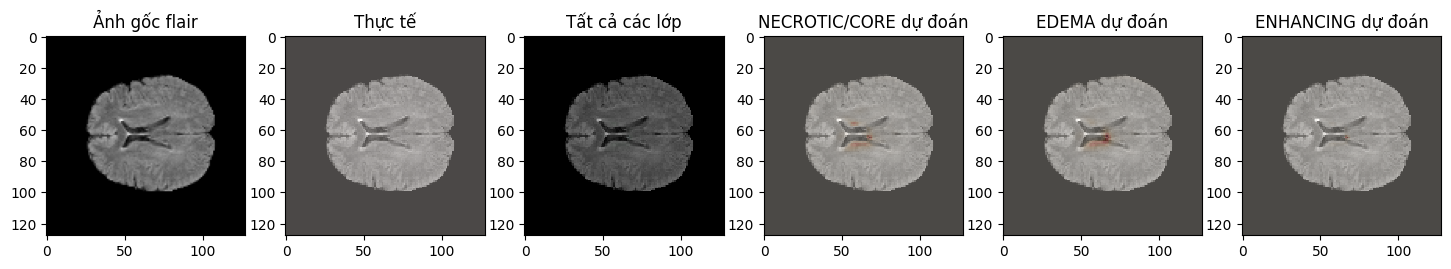

311
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

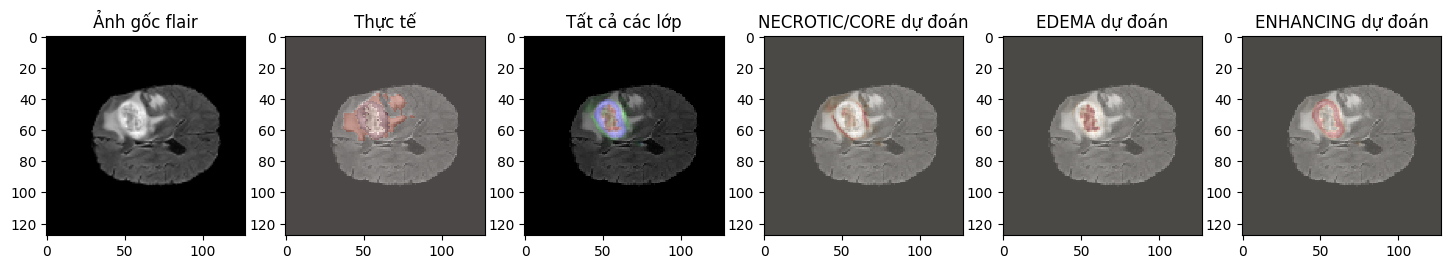

101
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

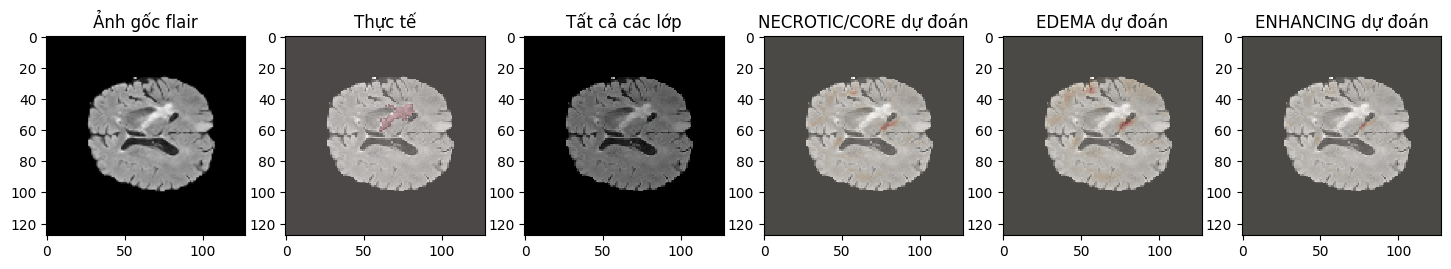

154
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

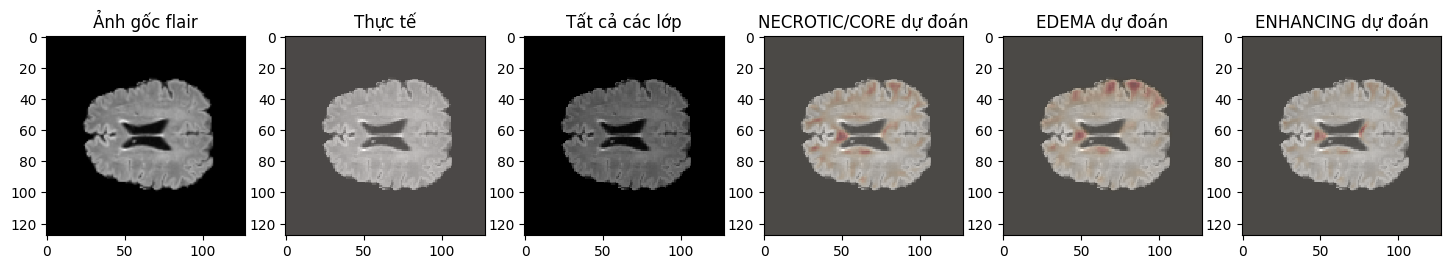

034
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

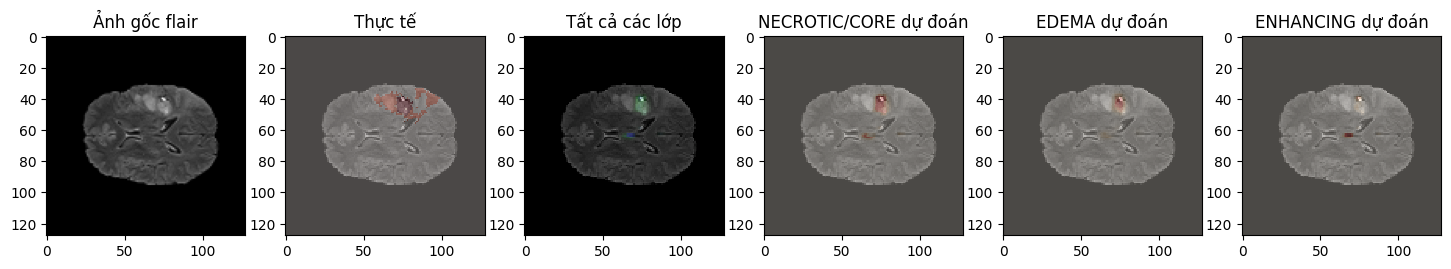

311
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

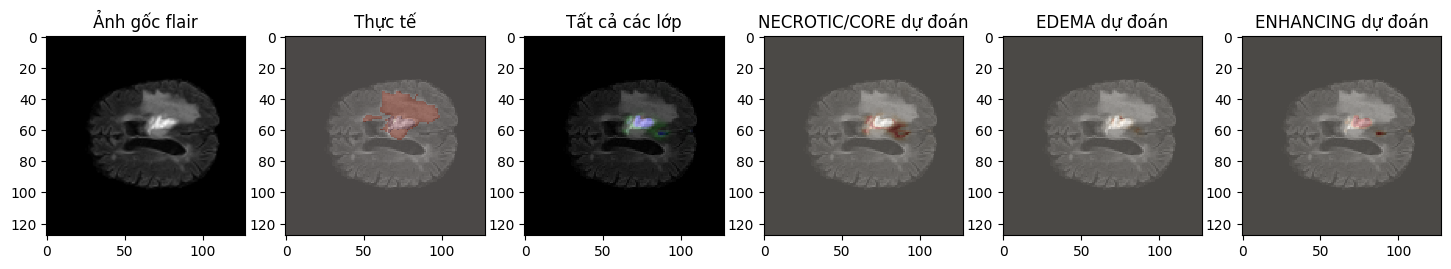

332
4/4 [==============================] - 10s 2s/step


<Figure size 1800x5000 with 0 Axes>

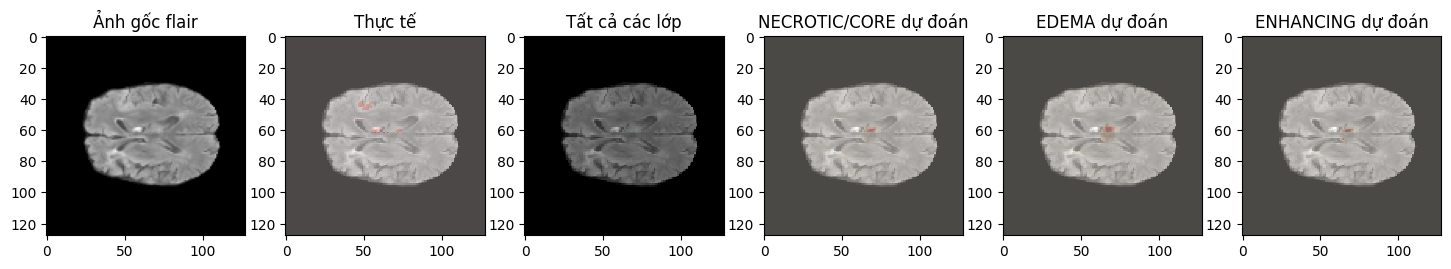

058
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

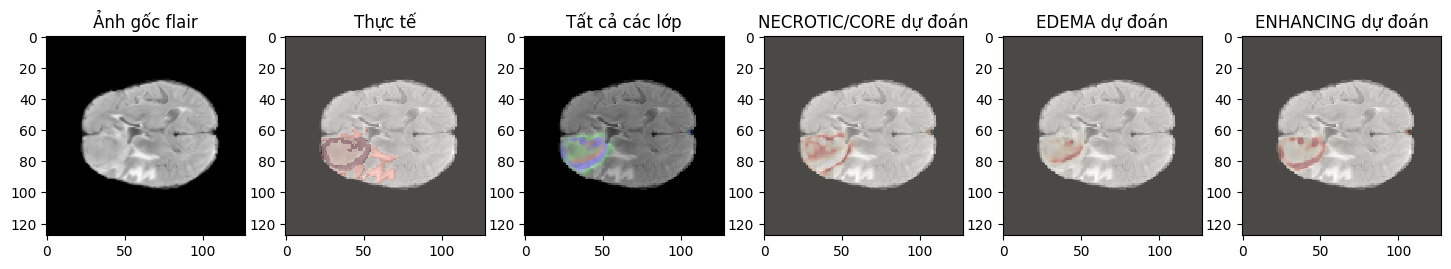

095
4/4 [==============================] - 7s 1s/step


<Figure size 1800x5000 with 0 Axes>

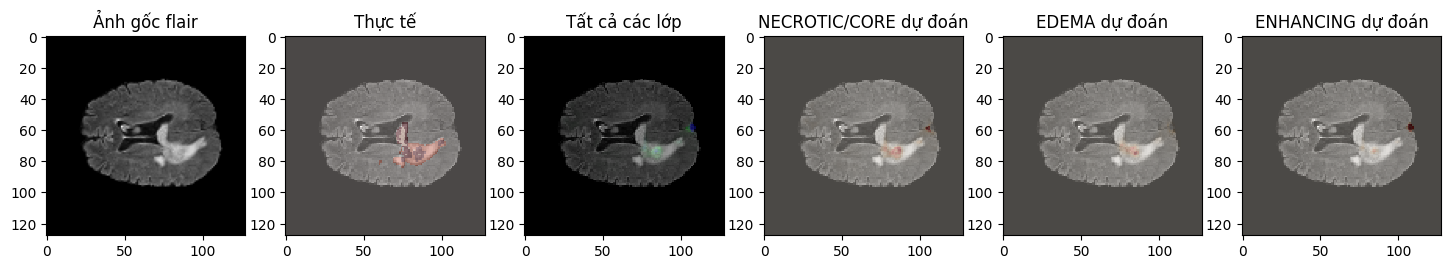

080
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

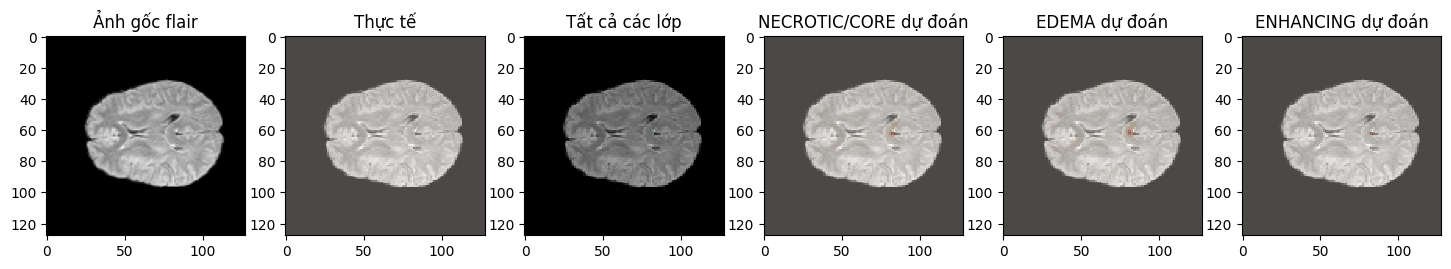

331
4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

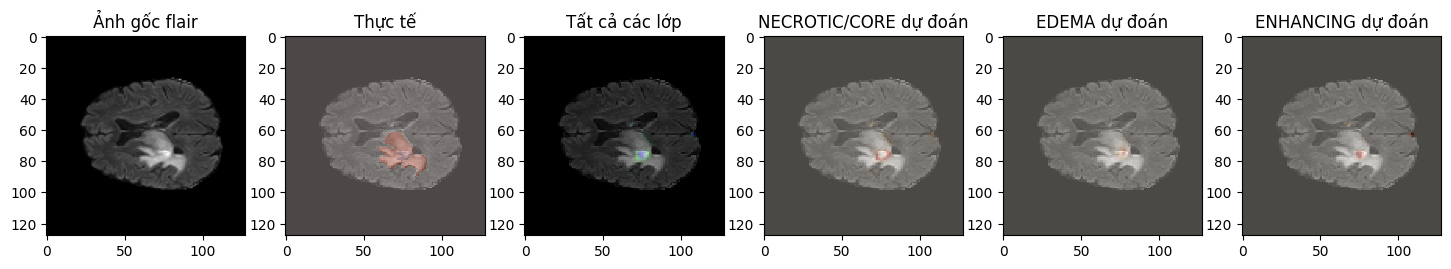

062
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

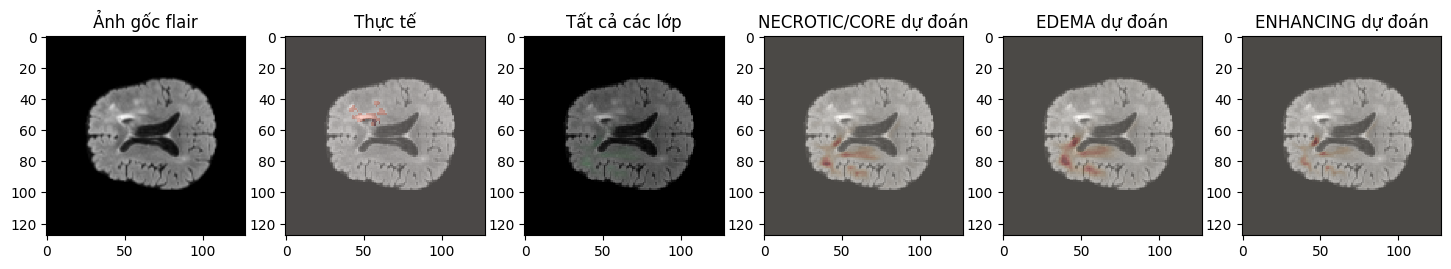

083
4/4 [==============================] - 9s 2s/step


<Figure size 1800x5000 with 0 Axes>

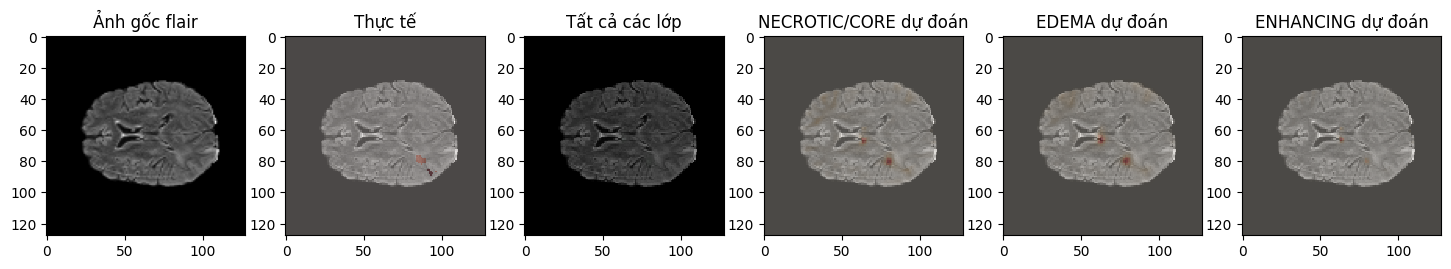

010
4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

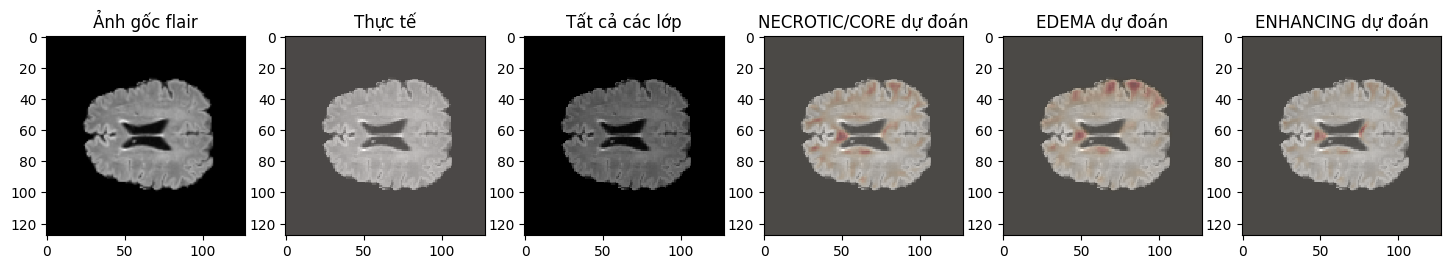

125


In [14]:

def predictByPath(case_path, case):
    # Lấy danh sách tệp trong thư mục case_path
    files = next(os.walk(case_path))[2]
    # Khởi tạo mảng X với kích thước (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2)
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    # Đường dẫn đến tệp ảnh flair
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    # Tải ảnh flair
    flair = nib.load(vol_path).get_fdata()
    # Đường dẫn đến tệp ảnh ce
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    # Tải ảnh ce
    ce = nib.load(vol_path).get_fdata() 
    # Lặp qua các lát cắt trong tập ảnh
    for j in range(VOLUME_SLICES):
        # Thay đổi kích thước lát cắt flair và thêm vào mảng inputs X
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        # Thay đổi kích thước lát cắt ce và thêm vào mảng inputs X
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
    # Dự đoán mặt nạ của tệp
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice=60):
    # Đường dẫn đến thư mục chứa dữ liệu của case
    path = f"E:\\learn\\nkkh\\detetection\\dataset\\for_nifti_sengmentation\\data_brast_2020\\data\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_{case}"
    # Tải ảnh mặt nạ thực tế
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    # Tải ảnh gốc
    # origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    # Dự đoán mặt nạ sử dụng hàm predictByPath
    p = predictByPath(path, case)
    # Rút trích các mặt nạ dự đoán cho các lớp khác nhau của khối u não
    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]
    # Tạo plot
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))
    # Hiển thị hình ảnh gốc
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].set_title('Ảnh gốc flair')
    # Hiển thị mặt nạ thực tế
    curr_gt = cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].set_title('Thực tế')
    # Hiển thị tất cả các lớp dự đoán
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('Tất cả các lớp')
    # Hiển thị mặt nạ cho lớp Edema
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} dự đoán')
    # Hiển thị mặt nạ cho lớp Core
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} dự đoán')
    # Hiển thị mặt nạ cho lớp Enhancing
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} dự đoán')
    plt.show()


import random as rd
# Hiển thị dự đoán cho các case khác nhau
# showPredictsById(case=test_ids[0][-3:])
for id in range(30):
    showPredictsById(case=test_ids[rd.randint(1,30)][-3:])
    print(test_ids[rd.randint(1,30)][-3:])




In [1]:


case = case=test_ids[3][-3:]
path = f"E:\\learn\\nkkh\\detetection\\dataset\\for_nifti_sengmentation\\data_brast_2020\\data\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # Chỉ sử dụng một lớp để đánh giá cho mỗi lớp

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

NameError: name 'test_ids' is not defined

: 

In [21]:


# model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# # Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# print("test loss, test acc:", results)

